In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

from IPython.display import Image, display

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib.path as mpath
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
## Import Lightning Climatology Data ##
filename = '/home/sbarc/students/nash/data/TRMM_LIS-OTD/LISOTD_LRTS_V2.3.2015.nc'

ds = xr.open_dataset(filename, decode_times=True)
ds1 = ds.sel(Latitude=33.75, Longitude=-118.75)
lightning_count = ds1.LRTS_COM_FR * ds1.LRTS_AREA
lightning_count.attrs['units'] = 'count/day'
lightning_count

<xarray.DataArray (Day_since_Jan_1_95_COM: 6812)>
array([98.538713, 99.090929, 99.636976, ...,  6.522304,  6.562643,  6.603078])
Coordinates:
  * Day_since_Jan_1_95_COM  (Day_since_Jan_1_95_COM) datetime64[ns] 1995-06-28 ... 2014-02-19
    Latitude                float32 33.75
    Longitude               float32 -118.75
Attributes:
    units:    count/day

/home/sbarc/students/nash/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


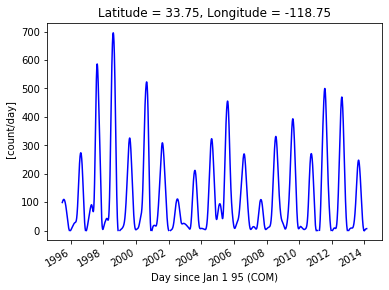

In [7]:
lightning_count.plot(color='b')

### Create an index of days AR in Central/Southern CA

In [8]:
ar_filename = '/home/sbarc/students/nash/data/ar_catalog/globalARcatalog_MERRA2_1980-2019_v2.0.nc'
ar_ds = xr.open_dataset(ar_filename)
ar_ds = ar_ds.squeeze()
## subset to central/southern California
ar_ds = ar_ds.sel(lat=slice(33.75, 36.25), lon=slice(360-121.25,360-118.75))

In [9]:
## Add the gridcells within region to create a list of landfall/AR days
ar_lfloc_list = ar_ds.lfloc.sum(dim=['lat', 'lon'])
ar_lfloc_list

<xarray.DataArray 'lfloc' (time: 57584)>
array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)
Coordinates:
    lev      float64 1e+03
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-05-31T18:00:00
    ens      float64 1.0

In [10]:
## Drop any date where no grid cells had an AR present
mask = ar_lfloc_list.where(ar_lfloc_list > 0, drop=True)
mask

<xarray.DataArray 'lfloc' (time: 1079)>
array([4., 4., 5., ..., 3., 3., 3.], dtype=float32)
Coordinates:
    lev      float64 1e+03
  * time     (time) datetime64[ns] 1980-01-09T06:00:00 ... 2019-05-19
    ens      float64 1.0

In [11]:
## create list of days where AR was present
time_list = pd.DatetimeIndex(mask.time.values).normalize()
time_list = pd.to_datetime(time_list)
time_list = time_list.drop_duplicates()
time_list

DatetimeIndex(['1980-01-09', '1980-01-11', '1980-01-12', '1980-01-13',
               '1980-01-14', '1980-02-16', '1980-02-17', '1980-02-18',
               '1980-03-02', '1980-03-03',
               ...
               '2019-01-17', '2019-01-18', '2019-02-02', '2019-02-13',
               '2019-03-01', '2019-03-02', '2019-03-05', '2019-04-16',
               '2019-05-16', '2019-05-19'],
              dtype='datetime64[ns]', length=742, freq=None)

In [32]:
counters = {}
for t in time_list:
    month = t.month
    if month in counters:
        counters[month] += 1
    else:
        counters[month] = 1

for k,v in counters.items():
    print('{}-{}'.format(k,v))

1-101
2-107
3-96
6-28
7-16
9-42
10-58
11-68
12-93
4-61
5-57
8-15


In [12]:
lightning_idx = time_list.slice_indexer(start=ds1.Day_since_Jan_1_95_COM.min().values, 
                                        end=ds1.Day_since_Jan_1_95_COM.max().values)
lightning_times = time_list[lightning_idx]
lightning_times

DatetimeIndex(['1995-09-03', '1995-12-12', '1996-01-27', '1996-01-31',
               '1996-02-03', '1996-02-18', '1996-02-19', '1996-02-20',
               '1996-03-05', '1996-04-01',
               ...
               '2012-12-03', '2012-12-22', '2012-12-24', '2013-01-24',
               '2013-03-03', '2013-03-19', '2013-04-07', '2013-04-08',
               '2013-05-16', '2013-09-01'],
              dtype='datetime64[ns]', length=362, freq=None)

In [13]:
lightning_ar = lightning_count.sel(Day_since_Jan_1_95_COM=lightning_times)
lightning_ar

<xarray.DataArray (Day_since_Jan_1_95_COM: 362)>
array([ 96.95119 ,        nan,   8.330753, ...,   8.951427,  31.326931,
       242.57277 ])
Coordinates:
  * Day_since_Jan_1_95_COM  (Day_since_Jan_1_95_COM) datetime64[ns] 1995-09-03 ... 2013-09-01
    Latitude                float32 33.75
    Longitude               float32 -118.75
Attributes:
    units:    count/day

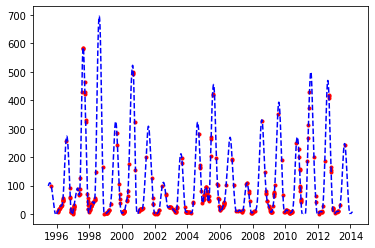

In [14]:
fig, ax = plt.subplots()
plt.plot_date(lightning_ar.Day_since_Jan_1_95_COM, lightning_ar.values, marker='.', color='red')
plt.plot_date(lightning_count.Day_since_Jan_1_95_COM, lightning_count.values, linestyle='--',
              color='b', marker=None)


In [33]:
lightning_ar.sum()/362.0

<xarray.DataArray ()>
array(72.030868)
Coordinates:
    Latitude   float32 33.75
    Longitude  float32 -118.75

(array([234.,  53.,  15.,  13.,   9.,   5.,   2.,  10.,   3.,   3.]),
 array([2.31206494e-01, 5.87105720e+01, 1.17189938e+02, 1.75669303e+02,
        2.34148669e+02, 2.92628034e+02, 3.51107400e+02, 4.09586765e+02,
        4.68066131e+02, 5.26545496e+02, 5.85024862e+02]),
 <a list of 10 Patch objects>)

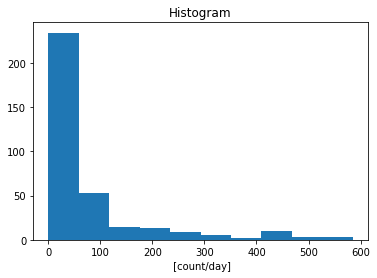

In [35]:
xr.plot.hist(lightning_ar)